# ProbNum 2025 Paper on Fast Gaussian Processes

https://probnum25.github.io/

## Setup

In [1]:
import fastgp
import qmcpy as qp 
import torch 
import numpy as np 
import scipy.stats
import time
import pandas as pd
from matplotlib import pyplot,cm,colors

In [2]:
import warnings
#warnings.simplefilter("ignore",[SyntaxWarning,UserWarning])

In [3]:
CISIZE = .99
ZSTAR = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
#pyplot.style.use("seaborn-v0_8-whitegrid")
import matplotlib.pyplot as plt
from tueplots.bundles import probnum2025
plt.rcParams.update(probnum2025())
_golden = (1 + 5 ** 0.5) / 2
MW1 = 240/72
MW2 = 500/72
MH1 = MW1/_golden
MH2 = MW2/_golden

In [4]:
torch.set_default_dtype(torch.float64)

## Test functions

In [5]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()
def f_curve_1d(x):
    return np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
def f_G(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
    assert x.ndim==2
    d = x.shape[1] 
    a = (torch.arange(1,d+1)-2)/2
    y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
    return y
def f_peaks(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
def f_brownian_motion(t, seed=23, numklterms=1000): # eq 6.8 https://artowen.su.domains/mc/Ch-processes.pdf
    assert t.size(1)==1
    j = torch.arange(numklterms)
    z_j = torch.from_numpy(np.random.Generator(np.random.PCG64(seed)).uniform(0,1,numklterms))
    bm = np.sqrt(2)/np.pi*(z_j*2/(2*j+1)*torch.sin((2*j+1)/2*np.pi*t)).sum(1)
    return bm
def f_branin_2d(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)): # https://www.sfu.ca/~ssurjano/branin.html
    assert x.size(1)==2
    x1,x2 = 15*x[:,0]-5,15*x[:,1]
    y = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*torch.cos(x1)+s
    return y
def f_camel_six_hump_2d(x): # https://www.indusmic.com/post/six-hump-camel-function
    assert x.size(1)==2
    x1,x2 = 6*x[:,0]-3,4*x[:,1]-2
    y = (4-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2
    return y 
def styblinski_tang(x): # https://www.sfu.ca/~ssurjano/stybtang.html
    x = 10*x-5
    y = 1/2*torch.sum(x**4-16*x**2+5*x,1)
    return y
def hartmann_6d(x):
    assert x.size(1)==6 
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
    A = torch.tensor([
        [10,   3,   17,   3.5, 1.7, 8],
        [0.05, 10,  17,   0.1, 8,   14],
        [3,    3.5, 1.7,  10,  17,  8],
        [17,   8,   0.05, 10,  0.1,  14]])
    P = 10**(-4)*torch.tensor([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]])
    y = -1/1.94*(2.58+torch.sum(alpha*torch.exp(-torch.einsum("ij,rij->ri",A,(x[:,None,:]-P)**2)),1))
    return y
def welch(x):
    assert x.size(1)==20
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20 = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,10],x[:,11],x[:,12],x[:,13],x[:,14],x[:,15],x[:,16],x[:,17],x[:,18],x[:,19]
    y = 5*x12/(1+x1)+5*(x4-x20)**2+x5+40*x19**3-5*x19+0.05*x2+0.08*x3-0.03*x6+0.03*x7-0.09*x9-0.01*x10-0.07*x11+0.25*x13**2-0.04*x14+0.06*x15-0.01*x17-0.03*x18
    return y

## Pointsets

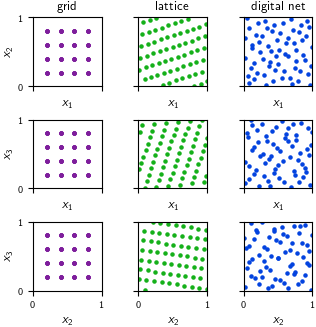

In [6]:
n = 2**6
d = 3
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)+2)[1:-1] for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,order="LINEAR",seed=7)(n)
dnb2 = qp.DigitalNetB2(d,seed=7,graycode=False,t_lms=32)
x_dnb2 = dnb2(n)
fig,ax = pyplot.subplots(nrows=3,ncols=3,sharey=True,sharex=True,figsize=(240/72,240/72))
S = 5
for j,(name,x) in enumerate(zip(["grid","lattice","digital net"],[grid,x_lattice,x_dnb2])):
    ax[0,j].set_title(name)#,fontsize="xx-large")
    ax[0,j].scatter(x[:,0],x[:,1],s=S,color=COLORS[j])
    ax[1,j].scatter(x[:,0],x[:,2],s=S,color=COLORS[j])
    ax[2,j].scatter(x[:,1],x[:,2],s=S,color=COLORS[j])
    ax[0,j].set_xlabel(r"$x_1$")#,fontsize="xx-large")
    ax[1,j].set_xlabel(r"$x_1$")#,fontsize="xx-large")
    ax[2,j].set_xlabel(r"$x_2$")#,fontsize="xx-large")
    for i in range(3):
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])
        # ax[i,j].set_xticks([0,1/4,1/2,3/4,1])
        # ax[i,j].set_xticklabels([r"$0$",r"$\frac{1}{4}$",r"$\frac{1}{2}$",r"$\frac{3}{4}$",r"$1$"])
        # ax[i,j].set_yticks([0,1/4,1/2,3/4,1])
        # ax[i,j].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_aspect(1)
ax[0,0].set_ylabel(r"$x_2$")#,fontsize="xx-large")
ax[1,0].set_ylabel(r"$x_3$")#,fontsize="xx-large")
ax[2,0].set_ylabel(r"$x_3$")#,fontsize="xx-large")
#fig.tight_layout()
fig.savefig("points.pdf")#,dpi=256,bbox_inches="tight")

## Kernel Matrix Structures

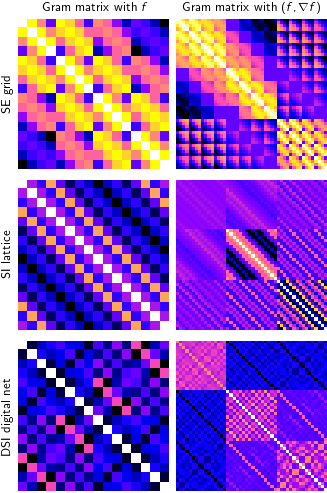

In [7]:
n = 2**4
d = 2
ngrid = np.round(n**(1/d))
assert ngrid**d==n
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = torch.from_numpy(qp.Lattice(d,order="LINEAR",seed=7)(n))
x_dnb2 = torch.from_numpy(qp.DigitalNetB2(d,seed=7,graycode=False,t_lms=32)(n))
i0mesh,i1mesh = torch.meshgrid(torch.arange(n),torch.arange(n),indexing="ij")
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
sgp = fastgp.StandardGP(d)
kmat_gauss = sgp.kernel(grid[:,None,:],grid[None,:,:]).detach()
kmat_gauss_grad = torch.cat([torch.cat([sgp.kernel(grid[:,None,:],grid[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fgp_lat = fastgp.FastGPLattice(d,alpha=4,lengthscales=2.5e-1)
kmat_lat = fgp_lat.kernel(x_lattice[:,None,:],x_lattice[None,:,:]).detach()
kmat_lat_grad = torch.cat([torch.cat([fgp_lat.kernel(x_lattice[:,None,:],x_lattice[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fgp_net = fastgp.FastGPDigitalNetB2(d,alpha=4,lengthscales=2.5e-1)
kmat_net = fgp_net.kernel(x_dnb2[:,None,:],x_dnb2[None,:,:]).detach()
kmat_net_grad = torch.cat([torch.cat([fgp_net.kernel(x_dnb2[:,None,:],x_dnb2[None,:,:],lbetas_grad[i0],lbetas_grad[i1]) for i1 in range(len(lbetas_grad))],-1) for i0 in range(len(lbetas_grad))],-2).detach()
fig,ax = pyplot.subplots(nrows=3,ncols=2,figsize=(MW1,MW1/2*3))
CMAP = "gnuplot2"
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss,kmat_lat,kmat_net])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax[i,0].imshow(kmat,cmap=CMAP)
    ax[i,0].set_ylabel(name)#,fontsize="xx-large")
for i,(name,kmat) in enumerate(zip(["SE grid","SI lattice", "DSI digital net"],[kmat_gauss_grad,kmat_lat_grad,kmat_net_grad])):
    #print(name) 
    #print(kmat[:4,:4])
    #print()
    ax[i,1].imshow(kmat,cmap=CMAP)
ax[0,0].set_title(r"Gram matrix with $f$")
ax[0,1].set_title(r"Gram matrix with $(f,\nabla f)$")
for i in range(3):
    for j in range(2):
        #ax[i,j].axis("off")
        ax[i,j].set_aspect(1)
        for spine in ["top","right","bottom","left"]:
            ax[i,j].spines[spine].set_visible(False)
        ax[i,j].set_yticks([]); ax[i,j].set_xticks([])
        #ax[i,j].get_yaxis().set_visible(False)
fig.savefig("gram_matrix_structures.pdf")#,dpi=256,bbox_inches="tight")

## Prior Draws

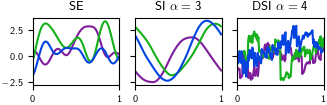

In [8]:
LW = None 
ndraws = 3
n = 127
t = 32
xticks = torch.linspace(0,1,n+2)[1:-1]
xbticks = torch.floor(xticks*2**t).to(torch.int64)
kmats = [
    ["SE", fastgp.StandardGP(1,lengthscales=1e-2,scale=2).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=2$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    [r"SI $\alpha=3$", fastgp.FastGPLattice(1,lengthscales=1e0,alpha=3).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=4$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=4)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"SI kernel $\alpha=5$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=5)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 2$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=2)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    #[r"DSI kernel $\alpha = 3$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=3)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n)],
    [r"DSI $\alpha = 4$", fastgp.FastGPDigitalNetB2(1,lengthscales=1e0,alpha=4).kernel(xticks[:,None,None],xticks[None,:,None]).detach()+1e-6*torch.eye(n)],
]
ncols = len(kmats)
fig,ax = pyplot.subplots(nrows=1,ncols=ncols,figsize=(MW1,MW1/3),sharex=True,sharey=True)
for i,(name,kmat) in enumerate(kmats):
    L = torch.linalg.cholesky(kmat)
    r = torch.randn(ndraws,n)
    draws = torch.einsum("ik,rk->ri",L,r)
    for j in range(ndraws):
        ax[i].plot(xticks,draws[j],color=COLORS[j],linewidth=LW)
        ax[i].set_title(name)#,fontsize="xx-large")
        ax[i].set_xlim([0,1])
        ax[i].set_xticks([0,1])
        #ax[i].set_xticks([0,1/4,1/2,3/4,1])
        #ax[i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
fig.savefig("draws.pdf")#,dpi=256,bbox_inches="tight")

## Benchmarks

In [9]:
funcs = [
    ("Ackley",1,f_ackley,False,False),
    ("Branin",2,f_branin_2d,False,True),
    ("Camel",2,f_camel_six_hump_2d,False,False),
    ("Styblinski",2,styblinski_tang,False,False),
    ("Hartmann",6,hartmann_6d,False,True),
    #("Welch",20,welch),
    ]
n = 2**4 # 2**10
gps = [
    ["SE lattice", lambda d,lbetas: fastgp.StandardGP([qp.Lattice(d,seed=7) for i in range(len(lbetas))],derivatives=lbetas,num_tasks=len(lbetas),noise=1e-3,requires_grad_noise=True,tfs_noise=(lambda x:torch.log10(x-1e-4),lambda x:torch.exp(x+1e-4)))],
    ["SI lattice", lambda d,lbetas: fastgp.FastGPLattice([qp.Lattice(d,seed=7) for i in range(len(lbetas))],derivatives=lbetas,alpha=3,num_tasks=len(lbetas))],
    ["DSI digital net", lambda d,lbetas: fastgp.FastGPDigitalNetB2([qp.DigitalNetB2(d,seed=7,randomize="DS") for i in range(len(lbetas))],derivatives=lbetas,alpha=4,num_tasks=len(lbetas))],
]
verbose_indent = 12
opt_steps = 250
verbose = max(1,opt_steps//5)
l2rerrors_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
l2rerrors_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_no_grad = torch.nan*torch.ones((len(funcs),len(gps)))
times_grad = torch.nan*torch.ones((len(funcs),len(gps)))
datas = {}
datas_grad = {}
for i,(fname,d,f,bake,bake_grad) in enumerate(funcs):
    print(fname)
    xquery = torch.from_numpy(qp.Halton(d,seed=17).gen_samples(2**12))
    yquery = f(xquery)
    for j,(name,gp_constructor) in enumerate(gps):
        print("    %s"%name)
        print("        nograd ")
        lbetas = [torch.zeros((1,d),dtype=int)]
        gp = gp_constructor(d,lbetas)
        x_next = gp.get_x_next(n)
        assert all((x_next_i==x_next[0]).all() for x_next_i in x_next)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,fastgp.FastGPLattice) and bake else f # possible Baker transform
        gp.add_y_next([f(x_next[0])])
        t0 = time.perf_counter()
        data = gp.fit(
            iterations = opt_steps,
            verbose_indent = verbose_indent,
            verbose = verbose,
            stop_crit_wait_iterations = opt_steps
        )
        times_no_grad[i,j] = time.perf_counter()-t0
        yhat = (gp.post_mean(xquery/2)+gp.post_mean(1-xquery/2))/2  if isinstance(gp,fastgp.FastGPLattice) and bake else gp.post_mean(xquery) # inverse Baker transform
        l2rerrors_no_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        print("            L2 relative error = %.2e\ttime = %.2e"%(l2rerrors_no_grad[i,j],times_no_grad[i,j]))
        datas[fname+"_"+name] = data
        print("        grad ")
        lbetas = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
        gp = gp_constructor(d,lbetas)
        x_next = gp.get_x_next(n*torch.ones(len(lbetas),dtype=int))
        #assert all((x_next_i==x_next[0]).all() for x_next_i in x_next)
        f_tf = (lambda x: f(1-2*torch.abs(x-1/2))) if isinstance(gp,fastgp.FastGPLattice) and bake_grad else f # possible Baker transform
        gp.add_y_next([f_grad_f(f_tf,x_next[i])[:,i] for i in range(len(lbetas))])
        t0 = time.perf_counter()
        data = gp.fit(
            iterations = opt_steps,
            verbose_indent = verbose_indent,
            verbose = verbose,
            stop_crit_wait_iterations = opt_steps,
        )
        times_grad[i,j] = time.perf_counter()-t0
        yhat = (gp.post_mean(xquery/2)+gp.post_mean(1-xquery/2))/2 if isinstance(gp,fastgp.FastGPLattice) and bake_grad else gp.post_mean(xquery) # inverse Baker transform
        l2rerrors_grad[i,j] = torch.linalg.norm(yhat-yquery)/torch.linalg.norm(yquery)
        datas_grad[fname+"_"+name] = data
        print("            L2 relative error = %.2e\ttime = %.2e"%(l2rerrors_grad[i,j],times_grad[i,j]))
    print()

Ackley
    SE lattice
        nograd 
             iter of 2.5e+02 | NMLL       | norm term  | logdet term
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                    0.00e+00 | 7.08e+03   | 7.09e+03   | -3.92e+01 
                    5.00e+01 | 2.13e+02   | 1.72e+02   | 1.13e+01  
                    1.00e+02 | 1.32e+02   | 7.97e+01   | 2.29e+01  
                    1.50e+02 | 1.10e+02   | 5.00e+01   | 3.05e+01  
                    2.00e+02 | 1.03e+02   | 3.84e+01   | 3.51e+01  
                    2.50e+02 | 9.96e+01   | 3.21e+01   | 3.81e+01  
            L2 relative error = 8.46e-02	time = 1.76e+00
        grad 
             iter of 2.5e+02 | NMLL       | norm term  | logdet term
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                    0.00e+00 | 3.51e+07   | 3.51e+07   | -7.68e+01 
                    5.00e+01 | 1.89e+05   | 1.89e+05   | 3.50e+01  
                    1.00e+02 | 6.23e+04   | 6.22e+04   | 5.29e+01  
   

In [10]:
with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
    print("l2rerrors_no_grad\n")
    print(l2rerrors_no_grad.numpy())
    print("\n\nl2rerrors_grad")
    print(l2rerrors_grad.numpy())
    print("\n\ntimes_no_grad")
    print(times_no_grad.numpy())
    print("\n\ntimes_grad")
    print(times_grad.numpy())

l2rerrors_no_grad

[[8.5e-02 6.6e-02 8.8e-02]
 [3.8e-01 5.4e-01 5.4e-01]
 [6.5e-01 5.2e-01 9.5e-01]
 [8.6e-01 9.1e-01 1.1e+00]
 [1.4e-01 1.3e-01 1.5e-01]]


l2rerrors_grad
[[1.9e+01 1.9e+01 1.7e+01]
 [4.6e+00 5.9e+00 3.6e+00]
 [1.1e+01 1.2e+01 9.9e+00]
 [1.4e+01 1.5e+01 7.4e+00]
 [2.5e+00 2.6e+00 2.5e+00]]


times_no_grad
[[1.8e+00 1.2e-01 1.6e-01]
 [1.4e-01 1.3e-01 1.7e-01]
 [1.3e-01 1.3e-01 1.6e-01]
 [1.4e-01 1.2e-01 1.7e-01]
 [1.6e-01 1.2e-01 1.6e-01]]


times_grad
[[3.2e-01 3.1e-01 4.3e-01]
 [8.0e-01 5.8e-01 7.5e-01]
 [7.2e-01 5.8e-01 7.9e-01]
 [7.4e-01 5.9e-01 7.9e-01]
 [4.9e+00 2.1e+00 3.1e+00]]


In [11]:
fnames = [item[0] for item in funcs]
_s = r"""  \begin{tabular}{r|%s|%s}
"""%("".join("cc" for name,gp in gps),"".join("cc" for name,gp in gps))
_s += "    " + "& " + r"\multicolumn{%d}{c|}{$L_2$ relative error} & \multicolumn{%d}{c}{time per optimization step} \\"%(2*len(gps),2*len(gps))+ "\n"
_s += "   "+" & "+" & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) +" & " + " & ".join(r"\multicolumn{2}{c}{%s}"%name for name,gp in gps) + r" \\" + "\n"
_s += "    "+"benchmark & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + " & " + " & ".join(r"$f$ & $(f, \nabla f)$" for name,gp in gps) + r" \\" + "\n"
_s += "    "+r"\hline" + "\n"
for i in range(len(l2rerrors_no_grad)):
    _t = ("        "+ "%s & "%fnames[i] 
    + " & ".join(r"%.1e & %.1e"%(l2rerrors_no_grad[i,j],l2rerrors_grad[i,j]) for j in range(l2rerrors_no_grad.size(1)))
    + " & "  
    + " & ".join(r"%.1e & %.1e"%(times_no_grad[i,j],times_grad[i,j]) for j in range(times_no_grad.size(1))) 
    + r" \\" + "\n")
    _t = _t.replace("e-0","e-").replace("e+0","e").replace("Styblinski","StyTang")
    _s += _t
_s += r"  \end{tabular}"
print(_s)

  \begin{tabular}{r|cccccc|cccccc}
    & \multicolumn{6}{c|}{$L_2$ relative error} & \multicolumn{6}{c}{time per optimization step} \\
    & \multicolumn{2}{c}{SE lattice} & \multicolumn{2}{c}{SI lattice} & \multicolumn{2}{c}{DSI digital net} & \multicolumn{2}{c}{SE lattice} & \multicolumn{2}{c}{SI lattice} & \multicolumn{2}{c}{DSI digital net} \\
    benchmark & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ & $f$ & $(f, \nabla f)$ \\
    \hline
        Ackley & 8.5e-2 & 1.9e1 & 6.6e-2 & 1.9e1 & 8.8e-2 & 1.7e1 & 1.8e0 & 3.2e-1 & 1.2e-1 & 3.1e-1 & 1.6e-1 & 4.3e-1 \\
        Branin & 3.8e-1 & 4.6e0 & 5.4e-1 & 5.9e0 & 5.4e-1 & 3.6e0 & 1.4e-1 & 8.0e-1 & 1.3e-1 & 5.8e-1 & 1.7e-1 & 7.5e-1 \\
        Camel & 6.5e-1 & 1.1e1 & 5.2e-1 & 1.2e1 & 9.5e-1 & 9.9e0 & 1.3e-1 & 7.2e-1 & 1.3e-1 & 5.8e-1 & 1.6e-1 & 7.9e-1 \\
        StyTang & 8.6e-1 & 1.4e1 & 9.1e-1 & 1.5e1 & 1.1e0 & 7.4e0 & 1.4e-1 & 7.4e-1 & 1.2e-1 & 5.9e-1 & 1.7e-1 

## 1d example

<>:58
<>:58
<>:58
<>:58
<>:58
<>:58
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_1551/3502487596.py:58
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_1551/3502487596.py:58
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_1551/3502487596.py:58


<function f_ackley at 0x1409bfb00>
	SE lattice
	SI lattice
	DSI digital net


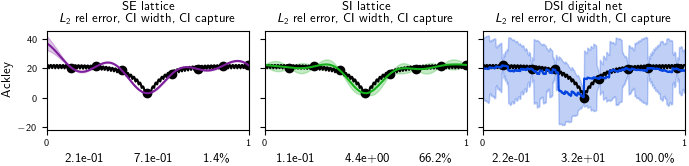

In [12]:
ALPHA = 0.25 
LW = None
d = 1
n = 2**3
nticks = 500
xticks = torch.linspace(0,1,nticks+2)[1:-1]
grid = torch.linspace(0,1,n+2)[1:-1,None]
lattice = qp.Lattice(d,seed=17) 
dnb2 = qp.DigitalNetB2(d,seed=7)
lbetas_no_grad = [torch.zeros((1,d),dtype=int)]
lbetas_grad = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps = [
    ["SE lattice", fastgp.StandardGP([lattice]*len(lbetas_no_grad),derivatives=lbetas_no_grad,num_tasks=len(lbetas_no_grad)),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 2$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,alpha=2),False],
    [r"SI lattice", fastgp.FastGPLattice([lattice]*len(lbetas_no_grad),derivatives=lbetas_no_grad,alpha=3,num_tasks=len(lbetas_no_grad)),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,alpha=4),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 2$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,alpha=2),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 3$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,alpha=3),False],
    [r"DSI digital net", fastgp.FastGPDigitalNetB2([dnb2]*len(lbetas_no_grad),derivatives=lbetas_no_grad,alpha=4,num_tasks=len(lbetas_no_grad)),False],
    #["GP + derivative, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=3), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=4), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 5$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,alpha=5), True],
    #["Fast GP + derivative, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,alpha=4), True],
]
funcs = [f_ackley]
fnames = ["Ackley"]
# funcs = [f_curve_1d,styblinski_tang,f_G,f_ackley,f_brownian_motion]
# fnames = ["smooth curve","Styblinski-Tang","G function","Ackley","Brownian motion"]
ncols = len(gps)
nrows = len(funcs)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MH2/3*nrows*1.2),sharex=True,sharey="row")
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    yticks = f(xticks[:,None])
    print(f)
    for i,(name,gp,grad) in enumerate(gps):
        print("\t"+name)
        x_next = gp.get_x_next(n=n*torch.ones(gp.num_tasks,dtype=int))
        if not grad:
            yf = [f(x_next[0])]
        else:
            yf = [f_grad_f(f,x_next[i])[:,i] for i in range(len(x_next))]
        gp.add_y_next(yf)
        ax[j,i].plot(xticks.cpu(),yticks.cpu(),color="k",linewidth=LW)
        data = gp.fit(iterations=250,verbose=0)
        pmean = gp.post_mean(xticks[:,None])[0]
        l2rerror = torch.linalg.norm(pmean-yticks)/torch.linalg.norm(yticks)
        ax[j,i].plot(xticks.cpu(),pmean.cpu(),color=COLORS[i],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])[0]
        ci_low = pmean-ZSTAR*torch.sqrt(pvar)
        ci_high = pmean+ZSTAR*torch.sqrt(pvar)
        ciwidth = torch.mean(ci_high-ci_low)
        capture = torch.mean(((yticks<ci_high)*(yticks>ci_low)).to(torch.float))
        ax[j,i].fill_between(xticks.cpu(),ci_high.cpu(),ci_low.cpu(),color=COLORS[i],alpha=ALPHA)
        ax[j,i].scatter(gp.x[0][:,0].cpu(),yf[0].cpu(),color="k",s=None)
        ax[j,i].set_xlim([0,1])
        ax[j,i].set_xlabel(r"%.1e"%l2rerror+"\ \ \ \ \ \ \ "+"%.1e"%ciwidth+"\ \ \ \ \ \ \ "+"%.1f"%(100*capture)+"\%")
for i,(name,gp,grad) in enumerate(gps):
    ax[0,i].set_title("%s\n%s, %s, %s"%(name,r"$L_2$ rel error"," CI width","CI capture"))#,fontsize="xx-large")
    #ax[-1,i].set_xlabel(r"$x$")#,fontsize="xx-large")
    ax[-1,i].set_xlim([0,1])
    ax[-1,i].set_xticks([0,1])
    # ax[-1,i].set_xticks([0,1/4,1/2,3/4,1])
    # ax[-1,i].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
for j,(f,fname) in enumerate(zip(funcs,fnames)):
    ax[j,0].set_ylabel(fname)#,fontsize="xx-large")
#fig.tight_layout()
#fig.savefig("./fgpr_figs/1d_gps.pdf")#,dpi=256,bbox_inches="tight")
fig.savefig("1d_gps_ackley.pdf")#,dpi=256,bbox_inches="tight")

## 2d example

In [17]:
d = 2
n = 2**8#2**12
f = f_ackley
nticks = 129
x1ticks = x2ticks = torch.linspace(0,1,nticks+2)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)

In [18]:
grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n)))
grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
assert len(grid)==n
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
dnb2_alpha2 = qp.DigitalNetB2(d,seed=7,alpha=2)
dnb2_alpha3 = qp.DigitalNetB2(d,seed=7,alpha=3)
dnb2_alpha4 = qp.DigitalNetB2(d,seed=7,alpha=4)

In [19]:
lbetas = [torch.zeros((1,d),dtype=int)]
#lbetas = [torch.zeros((1,d),dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
gps_grad = [
    ["SE lattice", fastgp.StandardGP(lattice,derivatives=lbetas)],
    ["SI lattice", fastgp.FastGPLattice(lattice,derivatives=lbetas,alpha=3)],
    ["DSI digital net", fastgp.FastGPDigitalNetB2(dnb2,derivatives=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=2", qp.FGPRDigitalNetB2(dnb2_alpha2,n,lbetas=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=3", qp.FGPRDigitalNetB2(dnb2_alpha3,n,lbetas=lbetas,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=4", qp.FGPRDigitalNetB2(dnb2_alpha4,n,lbetas=lbetas,alpha=4)],
]
times = torch.zeros(len(gps_grad))
for i,(name,gp) in enumerate(gps_grad):
    print(name) 
    if len(lbetas)==1:
        yf = [f(gp.get_x_next(n))]
    else:
        assert len(lbetas)==(1+d)
        yf = [f_grad_f(f,x_next_i)[:,i] for x_next_i in gp.get_x_next(n=n*torch.ones(gp.num_tasks,dtype=int))]
    gp.add_y_next(yf)
    t0 = time.perf_counter()
    data = gp.fit(
        #xticks,yticks,
        iterations=500,verbose=50,stop_crit_wait_iterations=500)
    times[i] = time.perf_counter()-t0

SE lattice
     iter of 5.0e+02 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 4.21e+08   | 4.21e+08   | -3.35e+03 
            5.00e+01 | 5.29e+06   | 5.29e+06   | -1.39e+03 
            1.00e+02 | 3.59e+05   | 3.59e+05   | -3.62e+02 
            1.50e+02 | 5.49e+04   | 5.45e+04   | -1.27e+02 
            2.00e+02 | 2.55e+04   | 2.51e+04   | -5.32e+01 
            2.50e+02 | 1.66e+04   | 1.62e+04   | -1.28e+01 
            3.00e+02 | 1.24e+04   | 1.19e+04   | 1.58e+01  
            3.50e+02 | 9.84e+03   | 9.33e+03   | 3.81e+01  
            4.00e+02 | 8.20e+03   | 7.67e+03   | 5.64e+01  
            4.50e+02 | 7.04e+03   | 6.50e+03   | 7.19e+01  
            5.00e+02 | 6.19e+03   | 5.64e+03   | 8.55e+01  
SI lattice
     iter of 5.0e+02 | NMLL       | norm term  | logdet term
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 2.82e+06   | 2.83e+06   | -1.84e+03 
            5.

<>:38
<>:38
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_1551/2908091153.py:38
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_1551/2908091153.py:55


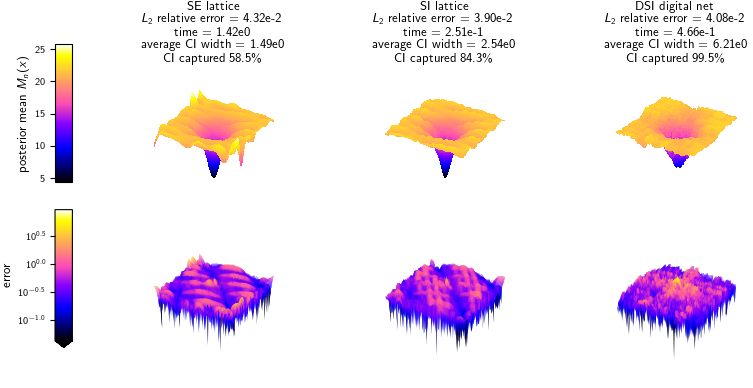

In [20]:
CMAP = cm.gnuplot2
nrows = 2
ncols = len(gps_grad)
fig = pyplot.figure(figsize=(MW2,MW2/ncols*nrows*.85))
ax = np.array([[fig.add_subplot(nrows,ncols,ncols*i+j+1,projection="3d") for j in range(ncols)] for i in range(nrows)],dtype=object)
pmeanmeshes = torch.vstack([gp.post_mean(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])
pvarmeshes = torch.vstack([gp.post_var(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])
pvarmeshes[pvarmeshes<0] = 0. 
ci_low = pmeanmeshes-ZSTAR*torch.sqrt(pvarmeshes)
ci_high = pmeanmeshes+ZSTAR*torch.sqrt(pvarmeshes)
ciwidth = ci_high-ci_low
capture = (ci_low<ymesh)*(ymesh<ci_high)
errors = torch.abs(pmeanmeshes-ymesh.cpu())
errormeshes = torch.log10(errors)
surfs = [None]*len(gps_grad)
for i,(name,gp) in enumerate(gps_grad):
    pmean_max,pmean_min = pmeanmeshes.max(),pmeanmeshes.min()
    error_max,error_min = torch.quantile(errormeshes,1),torch.quantile(errormeshes,.05)
    norm_pmean = colors.Normalize(vmin=pmean_min,vmax=pmean_max)
    norm_err = colors.Normalize(vmin=error_min,vmax=error_max)
    surfs[i] = ax[0,i].plot_surface(x1mesh.cpu(),x2mesh.cpu(),pmeanmeshes[i],
        cmap=CMAP,
        vmin=pmean_min,vmax=pmean_max,
        antialiased=False,rstride=1,cstride=1,edgecolor='none')
    surfs[i] = ax[1,i].plot_surface(x1mesh.cpu(),x2mesh.cpu(),errormeshes[i],
        cmap=CMAP,
        vmin=error_min,vmax=error_max,
        #facecolors=CMAP(norm_err(errormeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    l2rerror = torch.linalg.norm(errors[i])/torch.linalg.norm(ymesh)
    ax[0,i].set_title("%s\n"%name
        +(r"$L_2$ relative error = %.2e"%l2rerror).replace("e-0","e-")
        +"\n"
        +(r"time = %.2e"%times[i]).replace("e-0","e-").replace("e+0","e")
        +"\n"
        +(r"average CI width = %.2e"%ciwidth[i].mean()).replace("e-0","e-").replace("e+0","e")
        +"\n"
        +(r"CI captured %.1f"%(100*capture[i].to(torch.float).mean())).replace("e-0","e-").replace("e+0","e")+"\%")
    ax[0,i].set_zlim([pmean_min,pmean_max])
    #ax[1,i].set_zlim([errormeshes.min(),errormeshes.max()])
cax_pmean = fig.add_axes([
    ax[0,0].get_position().x0-0.2,
    ax[0,0].get_position().y0,
    .025,
    ax[0,0].get_position().y1-ax[0,0].get_position().y0,
])
cax_err = fig.add_axes([
    ax[1,0].get_position().x0-0.2,
    ax[1,0].get_position().y0,
    0.025,
    ax[1,0].get_position().y1-ax[1,0].get_position().y0,
])
cbar_pmean = fig.colorbar(cm.ScalarMappable(norm=norm_pmean,cmap=CMAP),cax_pmean,orientation="vertical",location="left",label=r"posterior mean $M_n(x)$")
cbar_err = fig.colorbar(cm.ScalarMappable(norm=norm_err,cmap=CMAP),cax_err,orientation="vertical",extend="min",location="left",label="error")
cbar_err.ax.set_yticklabels([r"$10^{%.1f}$"%tick for tick in cbar_err.ax.get_yticks()])
for i in range(ncols):
    for j in range(nrows):
        ax[j,i].axis("off")
        # ax[j,i].set_xlim([0,1]); ax[j,i].set_xticks([0,1])
        # ax[j,i].set_ylim([0,1]); ax[j,i].set_yticks([0,1])
        # ax[j,i].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # ax[j,i].xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        # ax[j,i].yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        # ax[j,i].zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        #ax[j,i].set_xlabel(r"$x_1$",fontsize="xx-large")
        #ax[j,i].set_ylabel(r"$x_2$",fontsize="xx-large")
    #ax[0,i].set_xlabel("test")
    #ax[0,i].set_zlabel(r"$f(\mathbf{x})$")#,fontsize="xx-large")
    #ax[1,i].set_zlabel(r"$|f(\mathbf{x})-f_{\mathrm{true}}(\mathbf{x})|$")#,fontsize="xx-large")
    #ax[0,i].set_zlim([pmeanmeshes.min(),pmeanmeshes.max()]); ax[i,j].set_yticks([0,1])
    #ax[1,i].zaxis._set_scale('log')
    #ax[1,i].set_zscale("log",base=10)
#fig.tight_layout()
fig.savefig("2d_gp.pdf")#,bbox_inches="tight")#,dpi=256)

In [ ]:
assert False

## Speed Comparison

In [ ]:
dvec = 2**torch.arange(0,5,dtype=int)
nvec = 2**torch.arange(0,10,dtype=int)
gps = [
    ["SE lattice", lambda d,n,lbetas: (qp.GPR(qp.Lattice(d),n,lbetas=lbetas),1.07e-01*torch.ones(d),torch.tensor([1.01e+01]))],
    ["SI lattice", lambda d,n,lbetas: (qp.FGPRLattice(qp.Lattice(d),n,lbetas=lbetas,alpha=3),1e0*torch.ones(d),torch.tensor([5e8]))],
    ["DSI digital net", lambda d,n,lbetas: (qp.FGPRDigitalNetB2(qp.DigitalNetB2(d),n,lbetas=lbetas,alpha=4),2.74e-07*torch.ones(d),torch.tensor([1.53e+09]))],
]

In [ ]:

print("dvec = %s"%str(dvec.numpy()))
print("nvec = %s"%str(nvec.numpy()))
print()
times = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
times_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors_grad = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
for j,d in enumerate(dvec):
    x_test = torch.from_numpy(qp.Halton(d,seed=7)(2**10))
    y_test = styblinski_tang(x_test)
    print("d = %d"%d)
    for i,n in enumerate(nvec):
        print("    n = %d"%n)
        for k,(name,gp_constructor) in enumerate(gps):
            # no grad
            lbetas = [torch.zeros(d,dtype=int)]
            gp,lengthscales,global_scale = gp_constructor(d,int(n),lbetas)
            y = styblinski_tang(gp.x)[:,None]
            data = gp.fit(y,opt_steps=250,verbose=25,verbose_indent=8,lengthscales=lengthscales,global_scale=global_scale)
            yhat = gp.post_mean(x_test)
            l2rerrors[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            times[k,j,i] = torch.mean(data["times"][2:-1]-data["times"][1:-2])#data["times"][0]
            print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name,l2rerrors[k,j,i],times[k,j,i]))
            if d>=16 and isinstance(gp,qp.GPR) and n>=128: continue 
            # grad
            lbetas_grad = [torch.zeros(d,dtype=int)]+[ej for ej in torch.eye(d,dtype=int)]
            gp,lengthscales,global_scale = gp_constructor(d,int(n),lbetas_grad)
            y = f_grad_f(styblinski_tang,gp.x)
            data = gp.fit(y,opt_steps=250,verbose=25,verbose_indent=8,lengthscales=lengthscales,global_scale=global_scale)
            yhat = gp.post_mean(x_test)
            l2rerrors_grad[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            times_grad[k,j,i] = torch.mean(data["times"][2:-1]-data["times"][1:-2])#data["times"][0]
            print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name+" + grad",l2rerrors_grad[k,j,i],times_grad[k,j,i]))
torch.save(nvec,"nvec.pth")
torch.save(l2rerrors,"l2rerrors.pth")
torch.save(l2rerrors_grad,"l2rerrors_grad.pth")
torch.save(times,"times.pth")
torch.save(times_grad,"times_grad.pth")

dvec = [ 1  2  4  8 16]
nvec = [  1   2   4   8  16  32  64 128 256 512]

d = 1
    n = 1
            iter of 250 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      0 | 1.02e+02        nan             | 1.00e-01        | [1.07e-01]	[1.01e+01]	[1.01e-06]
                     25 | 1.77e+01        nan             | 1.00e-01        | [1.07e-01]	[7.53e+01]	[1.01e-06]
                     50 | 1.08e+01        nan             | 1.00e-01        | [1.07e-01]	[1.79e+02]	[1.01e-06]
                     75 | 9.32e+00        nan             | 1.00e-01        | [1.07e-01]	[2.71e+02]	[1.01e-06]
                    100 | 8.72e+00        nan             | 1.00e-01        | [1.07e-01]	[3.53e+02]	[1.01e-06]
                    125 | 8.40e+00        nan             | 1.00e-01        | [1.07e-01]	[4.32e+02]	[1.01e-06]
                  

/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_34844/3968147311.py:1
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_34844/3968147311.py:2
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_34844/3968147311.py:3
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_34844/3968147311.py:4
/var/folders/xk/w1s5c54x0zv90dgqk3vpmbsw004hmz/T/ipykernel_34844/3968147311.py:5


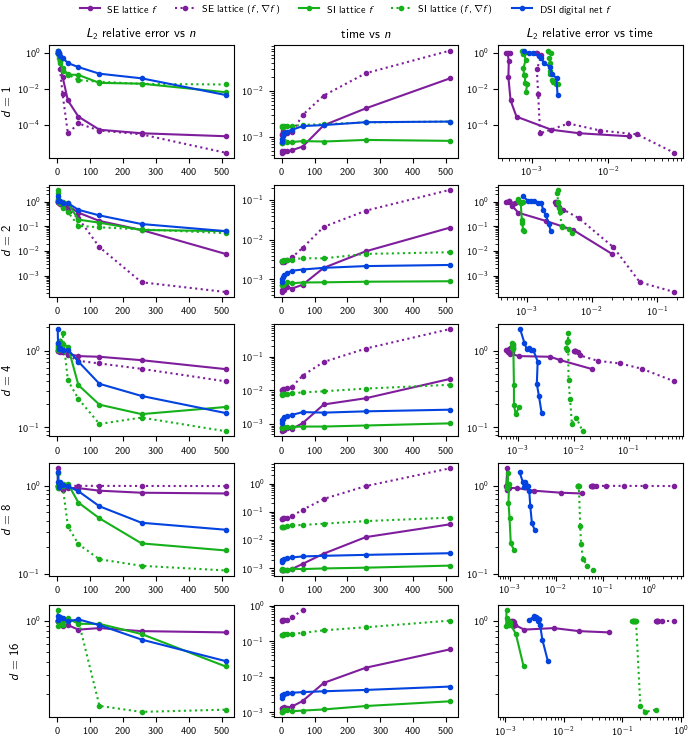

In [ ]:
nvec = torch.load("./fgpr_figs/speed_accuracy_comp_data/nvec.pth")
l2rerrors = torch.load("./fgpr_figs/speed_accuracy_comp_data/l2rerrors.pth")
l2rerrors_grad = torch.load("./fgpr_figs/speed_accuracy_comp_data/l2rerrors_grad.pth")
times = torch.load("./fgpr_figs/speed_accuracy_comp_data/times.pth")
times_grad = torch.load("./fgpr_figs/speed_accuracy_comp_data/times_grad.pth")
ncols = 3
# j_offset = 2
# nrows = len(dvec)-j_offset-1
j_offset = 0
nrows = len(dvec)-j_offset
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MH2/3*nrows))
S = None
LW = None
MARKER = "."
LINESTYLE = "dotted"
for j in range(j_offset,j_offset+nrows):
    for k in range(times.size(0)):
        label = gps[k][0]+r" $f$" if (j-j_offset)==0 else None
        ax[j-j_offset,0].plot(nvec,l2rerrors[k,j],marker=MARKER,color=COLORS[k],label=label,linewidth=LW,markersize=S)
        ax[j-j_offset,1].plot(nvec,times[k,j],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S)
        ax[j-j_offset,2].plot(times[k,j],l2rerrors[k,j],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S)
        if gps[k][0]=="DSI digital net": continue
        label_grad = (gps[k][0]+r" $(f,\nabla f)$") if (j-j_offset)==0 else None
        ax[j-j_offset,1].plot(nvec,times_grad[k,j],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        ax[j-j_offset,0].plot(nvec,l2rerrors_grad[k,j],marker=MARKER,color=COLORS[k],label=label_grad,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        ax[j-j_offset,2].plot(times_grad[k,j],l2rerrors_grad[k,j],marker=MARKER,color=COLORS[k],label=None,linewidth=LW,markersize=S,linestyle=LINESTYLE)
        # ax[j,2].scatter(times[k,j],l2rerrors[k,j],marker=MARKER,color=COLORS[k],label=None,s=S*10)
        # ax[j,2].scatter(times_grad[k,j],l2rerrors_grad[k,j],marker=MARKER,color=COLORS[k],label=None,s=S*10)
for j in range(j_offset,j_offset+nrows):
    for i in range(ncols):
        ax[j-j_offset,i].set_yscale("log",base=10)
    ax[j-j_offset,0].set_ylabel(r"$d=%d$"%dvec[j])#,fontsize="xx-large")
    ax[j-j_offset,2].set_xscale("log",base=10)
fig.legend(frameon=False,ncol=6,bbox_to_anchor=(.5,1.04),loc="upper center") # ,fontsize="xx-large"
ax[0,0].set_title(r"$L_2$ relative error vs $n$")#,fontsize="xx-large")
ax[0,1].set_title(r"time vs $n$")#,fontsize="xx-large")
ax[0,2].set_title(r"$L_2$ relative error vs time")#,fontsize="xx-large")
#fig.tight_layout()
fig.savefig("./fgpr_figs/speed_accuracy_comp.pdf")#,dpi=256,bbox_inches="tight")
#fig.savefig("./fgpr_figs/speed_accuracy_comp_trim.pdf")#,dpi=256,bbox_inches="tight")